In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from pathlib import Path
import xgboost as xgb
from sklearn import metrics
from itertools import combinations


# MODEL EXPLORATION

In [ ]:
# LOGISTIC REGRESSION
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# DATA PATHS
POSITIVES_PATH = Path("src/final_data/roadsigns/positive_samples_roadsigns_200.csv")
NEGATIVES_PATH_TRUE = Path("src/final_data/roadsigns/negative_samples_roadsigns_200.csv")
NEGATIVES_PATH_FALSE = Path("src/final_data/roadsigns/TMP_negative_samples_roadsigns_200.csv")
NEGATIVES_PATH_RANDOM = Path("src/final_data/roadsigns/TMP3_negative_samples_roadsigns_200.csv")

# POSITIVE SAMPLE BUILDINGS
POSITIVES = pd.read_csv(POSITIVES_PATH)

# NEGATIVE SAMPLE BUILDINGS
NEGATIVES_TRUE = pd.read_csv(NEGATIVES_PATH_TRUE)
NEGATIVES_FALSE = pd.read_csv(NEGATIVES_PATH_FALSE)
NEGATIVES_RANDOM = pd.read_csv(NEGATIVES_PATH_RANDOM)

# OUTPUTS
POSITIVES['label'] = 1
NEGATIVES_TRUE['label'] = 0
NEGATIVES_FALSE['label'] = 0
NEGATIVES_RANDOM['label'] = 0

# COMMON COLUMNS
POSITIVES.columns=[c.strip() for c in POSITIVES.columns]
NEGATIVES_TRUE.columns=[c.strip() for c in NEGATIVES_TRUE.columns]
NEGATIVES_FALSE.columns=[c.strip() for c in NEGATIVES_FALSE.columns]
NEGATIVES_RANDOM.columns=[c.strip() for c in NEGATIVES_RANDOM.columns]

common_columns = list(np.intersect1d(POSITIVES.columns, NEGATIVES_TRUE.columns))

# CONCATENATE POSITIVES AND NEGATIVES
DATA = pd.concat([POSITIVES[common_columns],
                  NEGATIVES_TRUE[common_columns],
                  NEGATIVES_FALSE[common_columns]])

DATA = DATA[['label'] + [col for col in DATA.columns if col != 'label']]

X = DATA.drop('label', axis=1)
y = DATA['label']

# Handling the date column
X['Date'] = pd.to_datetime(X['Date'])
X['Year'] = X['Date'].dt.year
X['Month'] = X['Date'].dt.month
X['Day'] = X['Date'].dt.day
X['DayOfWeek'] = X['Date'].dt.dayofweek
X.drop('Date', axis=1, inplace=True)

# Encode categorical variables
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()
for feature in categorical_features:
    X[feature] = X[feature].astype(str)

# Setting up the preprocessing pipeline for numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('scaler', StandardScaler())
])

# Setting up Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', numerical_pipeline, numerical_features)
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

X_train_preprocessed = np.nan_to_num(X_train_preprocessed, nan=np.nan)
X_test_preprocessed = np.nan_to_num(X_test_preprocessed, nan=np.nan)

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

performance = {}

for model_name, model in models.items():
    model.fit(X_train_preprocessed, y_train)
    y_pred = model.predict(X_test_preprocessed)
    accuracy = accuracy_score(y_test, y_pred)
    performance[model_name] = {'Accuracy': accuracy}

    # Generate classification report
    report = classification_report(y_test, y_pred)
    print(f"Classification Report for {model_name}:\n{report}\n")

print(performance)

# XGBOOST

In [ ]:
# XGBOOST
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# DATA PATHS
POSITIVES_PATH = Path("final_data/roadsigns/positive_samples_roadsigns_200.csv")
NEGATIVES_PATH_TRUE = Path("final_data/roadsigns/negative_samples_roadsigns_200.csv")
NEGATIVES_PATH_FALSE = Path("final_data/roadsigns/TMP_negative_samples_roadsigns_200.csv")
NEGATIVES_PATH_RANDOM = Path("final_data/roadsigns/TMP3_negative_samples_roadsigns_200.csv")

# POSITIVE SAMPLE roadsigns
POSITIVES = pd.read_csv(POSITIVES_PATH)

# NEGATIVE SAMPLE roadsigns
NEGATIVES_TRUE = pd.read_csv(NEGATIVES_PATH_TRUE)
NEGATIVES_FALSE = pd.read_csv(NEGATIVES_PATH_FALSE)
NEGATIVES_RANDOM = pd.read_csv(NEGATIVES_PATH_RANDOM)

# OUTPUTS
POSITIVES['label'] = 1
NEGATIVES_TRUE['label'] = 0
NEGATIVES_FALSE['label'] = 0
NEGATIVES_RANDOM['label'] = 0

# COMMON COLUMNS
POSITIVES.columns=[c.strip() for c in POSITIVES.columns]
NEGATIVES_TRUE.columns=[c.strip() for c in NEGATIVES_TRUE.columns]
NEGATIVES_FALSE.columns=[c.strip() for c in NEGATIVES_FALSE.columns]
NEGATIVES_RANDOM.columns=[c.strip() for c in NEGATIVES_RANDOM.columns]

common_columns = list(np.intersect1d(POSITIVES.columns, NEGATIVES_TRUE.columns))

# CONCATENATE POSITIVES AND NEGATIVES
DATA = pd.concat([POSITIVES[common_columns],
                  NEGATIVES_TRUE[common_columns],
                  NEGATIVES_FALSE[common_columns],
                  NEGATIVES_RANDOM[common_columns]])

DATA = DATA[['label'] + [col for col in DATA.columns if col != 'label']]

X = DATA#.drop('label', axis=1)
y = DATA['label']

X['has_roadsign'] = X['has_roadsign'].map({'True': True, True: True, 'False': False, False: False, '0': False})
X, y = X.drop(['label',
                'grid_id',
                'Date'], axis=1), X[['label']]

cats = X.select_dtypes(exclude=np.number).columns.tolist()

for col in cats:
   X[col] = X[col].astype(int)
   
# DETERMINE THE COLUMNS TO BE USED
X = X[['has_roadsign', 'Gemiddelde kijkrichting', 
       'Gemiddelde hoogte onderkant bord',
       'wind_gusts_10m', 
       'wind_direction_10m', 
       'Bouwwerk', 'Buispaal', 'Flespaal',
       'Hekwerk', 'Lichtmast', 'Mast',
       'Muur', 'Overig', 'Portaal', 'Scheiding', 'VRI-Mast']]

# SPLIT THE X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

# CREATING CLASSIFICATION MATRICES
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)
evals = [(dtrain_clf, "train"), (dtest_clf, "validation")]

# DEFINING HYPERPARAMETERS
best_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 1,
    "learning_rate": 0.01,
    "subsample": 0.8,
    "colsample_bytree": 1.0,
    "gamma": 0,
    "reg_alpha": 0.1,  
}

n = 1000

# MODEL TRAINING
model = xgb.train(
    params = best_params,
    dtrain = dtrain_clf, 
    num_boost_round = n, 
    verbose_eval = 250, 
    evals=evals,
    early_stopping_rounds=50,
)


y_pred_clf = model.predict(dtest_clf)
y_pred_labels = (y_pred_clf > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_labels)
percentage_correct = accuracy * 100

# FEATURE IMPORTANCE PLOT
xgb.plot_importance(model)
plt.show()

print(f"Percentage of correctly classified labels: {percentage_correct:.2f}%")


In [54]:
# SAVE MODEL
import pickle

# Save the XGBoost model as a pickle file
with open("models/roadsigns/FINAL_xgboost_model_roadsigns.pkl", "wb") as model_file:
    pickle.dump(model, model_file)

# Print a message indicating that the model has been saved
print("XGBoost model saved successfully as a pickle file.")

XGBoost model saved successfully as a pickle file.


In [ ]:
# HYPERPARAMETER TUNING
# RUN ALLEEN VOOR TUNING
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    # 'reg_alpha': [0, 0.01, 0.1],  
    # 'reg_lambda': [0, 0.01, 0.1]  
}
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', n_estimators=100)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=2)
grid_search.fit(X_train, y_train)

print("Beste hyperparameters gevonden:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

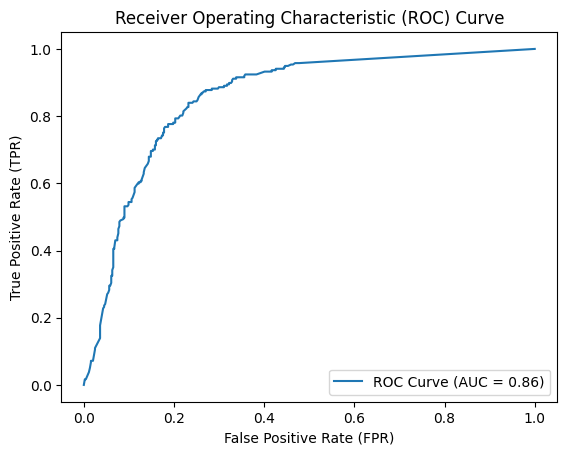

In [55]:
# ROC Curve
y_pred_clf = model.predict(dtest_clf)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_clf)
auc = metrics.roc_auc_score(y_test, y_pred_clf)
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(auc))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc=4)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()